**MONTECARLO MODEL for STOCK PREDICTION**

Libraries to import

In [1]:
##Generic library for Array and Data-time format
import datetime as dt
import numpy as np
import pandas as pd
from pandas import DataFrame

##Generic library to create plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.subplots as sp

##Generic library to retrieve stock-Data
import yfinance as yf



In [2]:
##Return the yfinance.Ticker object that stores all the relevant stock informations
import warnings

##Return the DATA INFORMATIONS
def month_year():
    now = dt.datetime.now()
    return now.day, now.month, now.year

def get_stock_data(isin_string):
    try:
        stock_ticker = isin_string
        stock_data = yf.Ticker(stock_ticker)
        stock_info = stock_data.info  # Effettua una richiesta per ottenere le informazioni
        return stock_data
    except ValueError as e:
        print(f"Errore nel recuperare i dati per {isin_string}: {e}")
        return None
    except Exception as e:
        print(f"Si è verificato un errore non previsto per {isin_string}: {e}")
        return None



##Return the hystorical data with date expressed as string --> Suitable for calculations
def get_stock_with_date_index_data(
    stock_data, category, start_date, end_date, ma_period=200
) -> DataFrame | DataFrame:
    full_date_range = pd.date_range(start=start_date, end=end_date, freq="D")
    try:
        if isinstance(stock_data, yf.Ticker):
            hist_data = stock_data.history(start=start_date, end=end_date)
            hist_data.index = hist_data.index.strftime("%Y-%m-%d")
            hist_data = hist_data.reindex(full_date_range.strftime("%Y-%m-%d"))
            hist_data.infer_objects().ffill(inplace=True)

            hist_data_to_return = pd.DataFrame(
                index=full_date_range.strftime("%Y-%m-%d"),
                columns=["symbol","category","stock_price", "volume", "MA200", "OBV"],
            )
            hist_data_to_return["stock_price"] = hist_data["Close"]
            hist_data_to_return["volume"] = hist_data["Volume"]
            hist_data_to_return["category"] = category
            hist_data_to_return["symbol"] = stock_data.ticker
            hist_data_to_return["MA200"] = (
                hist_data_to_return["stock_price"].rolling(window=ma_period).mean()
            )

            # Calcolo dell'indicatore OBV
            hist_data_to_return["OBV"] = np.where(
                hist_data_to_return["stock_price"].diff() > 0,  # type: ignore
                hist_data_to_return["volume"],
                -hist_data_to_return["volume"],
            )
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', FutureWarning)
                hist_data_to_return.ffill(inplace=True)
            return hist_data_to_return
        else:
            raise ValueError(f"stock_data must be a yf.Ticker object, got {type(stock_data)} instead.")
    except Exception as e:
        print(f"Error: {e}")
        hist_data_to_return = pd.DataFrame(
            index=full_date_range.strftime("%Y-%m-%d"),
            columns=["symbol","stock_price", "volume", "MA200", "OBV"],
        )
        return hist_data_to_return

This Montecarlo Model is built based on the definition of **daily logarithmic return (dlr)** as function of the **drift** and **volatility** :

$$
dlr = ln \frac{price\_today}{price\_yesterday} \rightarrow price\_today = \exp{(dlr)} * price\_yesterday 
$$

$$
drift \sim mean(dlr) - \frac{\hat{V}(dlr)}{2}   
$$ 

$$
volatility \sim \sigma(dlr) * Z 
$$

$$
dlr = drift + volatility
$$

Where **Z** is coming from a chosen random distribution (i.e. normal, uniform)

Here, we start to retrieve data from the ticker that we are interested.

In [60]:
### GENERIC INFORMATION ABOUT stock and its HYSTORICAL BEHAVIOR
# Time Informations
day, month, year = month_year()

##stock_under_test = input("Enter the stock ticker symbol: ")
##start_date = input("Enter the start date (YYYY-MM-DD): ")
##category = input("Insert Category ETF, Crypto, Stock")

stock_under_test = "IE00BK5BQT80"
start_date = "2019-07-23"
category = "ETF"



#end_date = "2024-10-11"

end_date = f"{year}-{month}-{day}"
# 
stock_data_object = get_stock_data(stock_under_test)
stock_dataFrame   = get_stock_with_date_index_data(stock_data=stock_data_object,category=category,start_date=start_date,end_date=end_date,ma_period=200)

stock_prices      = (stock_dataFrame["stock_price"])
#Last value of the Ticker
stock_dataFrame["stock_price"].iloc[-1]

139.97999572753906

In [61]:
## Daily Logarithmic Return

logret      = np.log(stock_prices/stock_prices.shift(1))

## Drift and Volatility
number_simulation = 10**6

uniform_or_normal = "normal"

if uniform_or_normal == "uniform":
    Z           = np.random.uniform(-1,+1,number_simulation)
    est_error   = np.std(logret)/np.sqrt(number_simulation)
else:
    Z           = np.random.normal(0,1,(number_simulation)) 
    est_error   = 3*np.std(logret)/np.sqrt(number_simulation)

drift       = np.mean(logret) - np.var(logret)/2
volatility  = np.std(logret) * Z 

print(f"With {uniform_or_normal} distribution , your error is : {est_error}")

With normal distribution , your error is : 2.8322971933848543e-05


In [62]:
## Today Price calculation

today_price = stock_prices.iloc[-1] * np.exp(drift+volatility)

df_today_price = pd.DataFrame(today_price)

#df_today_price.plot(title=f"{stock_under_test} Montecarlo Prediction",ylabel="Stock Price $",xlabel="Frequency",figsize=(20,10),legend=None)

#df_today_price.plot(kind='hist', bins = 100, title=f"{stock_under_test} Today_Price Prediction",figsize=(20,10),xlabel="Stock Price",ylabel="Frequency")

print(f"Average Stock Today Price : {df_today_price.mean()}")

Average Stock Today Price : 0    140.019403
dtype: float64


**MODEL For Future Predictions**

In order to choose the proper number of simulation, we have to take into account that the error related to the estimation is :

$$
\epsilon = \left\{ \begin{array}{rcl} \frac{3 \sigma}{\sqrt N} & \small{Normal\space Distribution} \\
\frac{\sigma}{\sqrt N} & \small{Uniform\space Distribution}
\end{array}\right.
$$

where **N = number of simulations**

With uniform distribution , your error is : 0.00029855033805328417
Estimated Average Stock price : 144.775811964423
Simulations above the estimated average : 487 , below the estimated average : 513
Simulations above the last price : 742 , below the last price : 258
Estimated Average Gain for 250 days and 1000 number_simulation is : 3.4260725698396652 % 


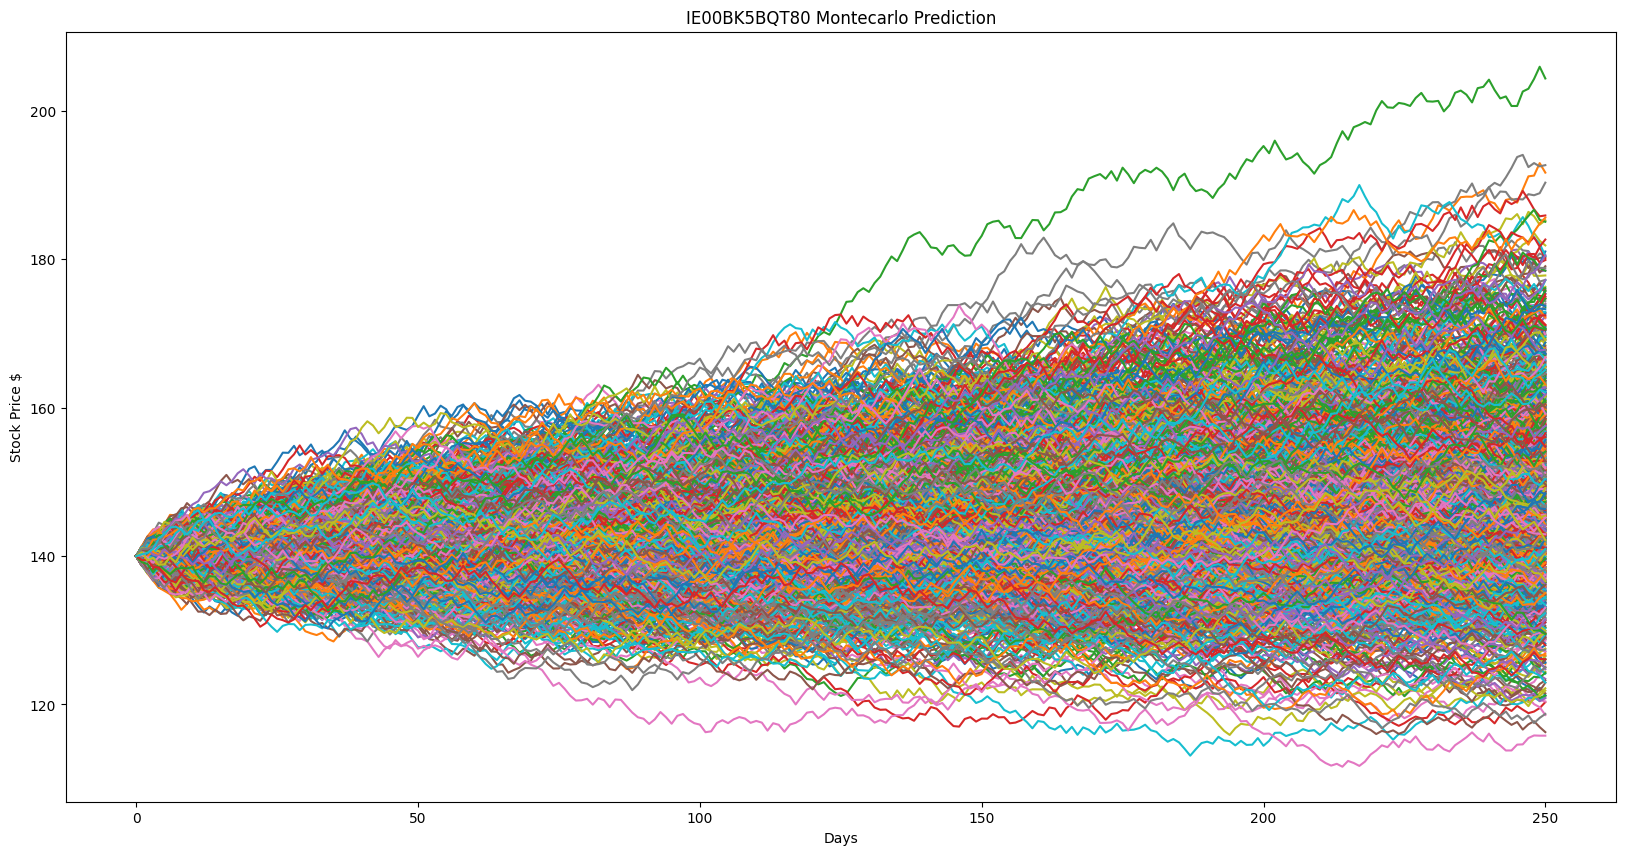

In [75]:
## Drift and Volatility
## fp = future predictions

number_simulation_fp = 10**6
days_to_predict_fp   = 250

uniform_or_normal = "uniform"

if uniform_or_normal == "uniform":
    Z_fp           = np.random.uniform(-1,+1,(days_to_predict_fp,number_simulation_fp))
    est_error_fp   = np.std(logret)/np.sqrt(number_simulation_fp)
else:
    Z_fp           = np.random.normal(0,1,(days_to_predict_fp,number_simulation_fp))
    est_error_fp   = 3*np.std(logret)/np.sqrt(number_simulation)


print(f"With {uniform_or_normal} distribution , your error is : {est_error_fp}")

## Array with rows = days_to_predict , columns = number_simulation_fp

## Z_fp           = np.random.normal(0,1,((days_to_predict_fp,number_simulation_fp)))  

# drift       = np.mean(logret) - np.var(logret)/2 --> it is not affected by the number of days to predict

volatility_fp  = np.std(logret) * Z_fp

## Just to have exponential daily return as pdDataFrame for further calculations

exponential_daily_logarithmic_return = np.exp(drift+volatility_fp)

df_exponential_daily_logarithmic_return = pd.DataFrame(exponential_daily_logarithmic_return)

## pd.DataFrame for future_prices ---> n_rows = days_to_predict_fp + 1 (because row = 0 is filled with the latest price retrieved from Yahoo Finance) , n_colums = number_simulation_fp

future_prices = pd.DataFrame(np.zeros((days_to_predict_fp+1,number_simulation_fp)))

future_prices.iloc[0] = stock_prices.iloc[-1] ## Last stock price from Yf

## We implement the formula described at the beginning

for i in range (1,days_to_predict_fp+1):
    future_prices.iloc[i] = future_prices.iloc[i-1] * df_exponential_daily_logarithmic_return.iloc[i-1]

future_prices.plot(title=f"{stock_under_test} Montecarlo Prediction",ylabel="Stock Price $",xlabel="Days",figsize=(20,10),legend=None)

#future_prices.plot(kind='hist',bins= 100, title=f"{stock_under_test} Montecarlo Prediction",figsize=(20,10),xlabel="Days",ylabel="Stock Price $",legend=None)

# Array that contains the average of each row of future_prices
array_mean_future_prices = future_prices.mean()

# Simulations above the average
sims_above_average = (future_prices.mean() >= array_mean_future_prices.mean()).sum()
# Simulations below the average
sims_below_average = (future_prices.mean() < array_mean_future_prices.mean()).sum()

# Simulations above last price
sims_above_last_price = (future_prices.mean() >= stock_prices.iloc[-1]).sum()
# Simulations below last price
sims_below_last_price = (future_prices.mean() < stock_prices.iloc[-1]).sum()

 

# Comparison respect to the last value of stock_prices
gain_future_prices = ((array_mean_future_prices.mean() - stock_prices.iloc[-1])/(stock_prices.iloc[-1]))*100

print(f"Estimated Average Stock price : {array_mean_future_prices.mean()}")
print(f"Simulations above the estimated average : {sims_above_average} , below the estimated average : {sims_below_average}")
print(f"Simulations above the last price : {sims_above_last_price} , below the last price : {sims_below_last_price}")
print(f"Estimated Average Gain for {days_to_predict_fp} days and {number_simulation_fp} number_simulation is : {gain_future_prices} % ")



In [6]:
### For the histogram it is needed to calculate the proper value for bins in order to avoid spread of information

Q1 = future_prices.quantile(0.25)
Q3 = future_prices.quantile(0.75)
IQR = Q3 - Q1


# Freedman-Diaconis rule to find the optimal width for the bins
bin_width = 2 * IQR * (len(future_prices) ** (-1/3))
# Number of bins
bins_fd = ((future_prices.max() - future_prices.min()) / bin_width)

# Plotta l'istogramma con il numero di bins calcolato
plt.hist(future_prices, bins=bins_fd, alpha=0.7)
plt.title(f'{stock_under_test} Future Prices')
plt.xlabel('Valore')
plt.ylabel('Frequenza')
plt.show()

NameError: name 'future_prices' is not defined